In [29]:
# Inside-Out MuSe (PyTorch, single file, concise)
# - Ports anchor "outside" residual space + outward-normal coherence into MuSe attention
# - Provides a transformer wrapper with (y, loss) API like your Inside-Out Transformer
#
# Quick start:
#   model = IOMuSeTransformer(vocab_size=50_000, d_model=768, n_layer=6, n_head=12)
#   y, loss = model(idx, targets)  # loss=None if targets is None

import math
from dataclasses import dataclass
from typing import Optional, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F

# ------------------------------------------------------------
# Utils
# ------------------------------------------------------------
def _init_trunc_normal_(w, std=0.02):
    nn.init.trunc_normal_(w, std=std, a=-2*std, b=2*std)

def rms_norm(x, eps=1e-6):  # (kept for parity; unused by default)
    return x * torch.rsqrt(x.pow(2).mean(dim=-1, keepdim=True) + eps)

def _stable_logsumexp(x, dim=-1):
    m = x.max(dim=dim, keepdim=True).values
    return m.squeeze(dim) + torch.log((x - m).exp().sum(dim=dim))

# ------------------------------------------------------------
# Anchor Field: soft nearest anchor & residual (outside component)
# ------------------------------------------------------------
class AnchorField(nn.Module):
    def __init__(self, d_model, n_anchors=64, beta=1.5):
        super().__init__()
        self.anchors = nn.Parameter(torch.randn(n_anchors, d_model) * 0.02)
        self.beta = beta

    def forward(self, h):
        """
        h: (B, T, d)
        returns:
          r: residual outside component (B, T, d)
          u: normalized outward normals (B, T, d)
          h_anchor: soft anchor reconstruction (B, T, d)
          w: soft assignments (B, T, n_anchors)
        """
        A = F.normalize(self.anchors, dim=-1)      # (A, d)
        h_n = F.normalize(h, dim=-1)               # (B, T, d)
        sim = torch.einsum("btd,ad->bta", h_n, A)  # (B, T, A)
        w = F.softmax(self.beta * sim, dim=-1)
        h_anchor = torch.einsum("bta,ad->btd", w, A)
        r = h - h_anchor
        u = F.normalize(r, dim=-1)
        return r, u, h_anchor, w
# ------------------------------------------------------------
# Attention with RoPE + expressive attention (EA) weighting
# ------------------------------------------------------------
class AnchorAttention(nn.Module):
    def __init__(
        self,
        d_model,
        n_head,
        dropout=0.0,
        lambda_normal=0.15,
        use_rope=True,
        rope_base=10000.0,
        attention_style="ea",  # "ea" (paper) or "dpa" (classic softmax)
    ):
        super().__init__()
        assert d_model % n_head == 0
        self.n_head = n_head
        self.d_head = d_model // n_head
        self.q_proj = nn.Linear(d_model, d_model, bias=False)
        self.k_proj = nn.Linear(d_model, d_model, bias=False)
        self.v_proj = nn.Linear(d_model, d_model, bias=False)
        self.o_proj = nn.Linear(d_model, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        self.lambda_normal = lambda_normal
        self.use_rope = use_rope
        self.rope_base = rope_base
        assert self.d_head % 2 == 0, "RoPE requires an even head dimension"
        self.attention_style = attention_style  # "ea" or "dpa"
        for p in self.parameters():
            if p.dim() > 1:
                _init_trunc_normal_(p)

    # ---- RoPE helpers (computed on the fly, like nanochat) ----
    def _rope_cache(self, T, Dh, device, dtype):
        # frequencies per pair of dims
        freqs = 1.0 / (self.rope_base ** (torch.arange(0, Dh, 2, device=device, dtype=dtype) / Dh))
        t = torch.arange(T, device=device, dtype=dtype)
        ang = torch.outer(t, freqs)  # (T, Dh/2)
        cos = ang.cos()[None, None, :, :]  # (1,1,T,Dh/2)
        sin = ang.sin()[None, None, :, :]  # (1,1,T,Dh/2)
        return cos, sin

    def _apply_rope(self, x, cos, sin):
        # x: (B,H,T,Dh)
        x1 = x[..., ::2]
        x2 = x[..., 1::2]
        xr1 = x1 * cos - x2 * sin
        xr2 = x1 * sin + x2 * cos
        return torch.stack((xr1, xr2), dim=-1).flatten(-2)

    def forward(self, r, u, attn_mask=None):
        """
        r: residuals (B, T, d)
        u: outward unit normals (B, T, d)
        returns: (B, T, d)
        """
        B, T, D = r.shape
        H, Dh = self.n_head, self.d_head

        q = self.q_proj(r).view(B, T, H, Dh).transpose(1, 2)  # (B,H,T,Dh)
        k = self.k_proj(r).view(B, T, H, Dh).transpose(1, 2)
        v = self.v_proj(r).view(B, T, H, Dh).transpose(1, 2)

        # --- RoPE: rotate Q/K per position (on the fly) ---
        if self.use_rope:
            cos, sin = self._rope_cache(T, Dh, q.device, q.dtype)
            q = self._apply_rope(q, cos, sin)
            k = self._apply_rope(k, cos, sin)

        # base similarity (z)
        att_logits = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(Dh)  # (B,H,T,T)

        # outward-normal coherence penalty: D_ij = 1 - (u_i · u_j)
        u_h = u.view(B, T, H, Dh).transpose(1, 2)  # (B,H,T,Dh)
        norm_sim = torch.matmul(u_h, u_h.transpose(-2, -1))  # (B,H,T,T)
        penalty = (1.0 - norm_sim)

        if self.attention_style.lower() == "ea":
            # Expressive attention weighting (paper): w ~ z^2/(1+z^2)
            z2 = att_logits.pow(2)
            scores = z2 / (1.0 + z2)
            # incorporate coherence as a multiplicative downweighting
            if self.lambda_normal > 0:
                scores = scores * torch.exp(-self.lambda_normal * penalty)
            # mask as zero weight, then normalize
            if attn_mask is not None:
                scores = scores.masked_fill(attn_mask == 0, 0.0)
            denom = scores.sum(dim=-1, keepdim=True).clamp_min(1e-9)
            w = scores / denom
        else:
            # Classic dot-product attention with penalty in logit space
            att = att_logits - self.lambda_normal * penalty
            if attn_mask is not None:
                att = att.masked_fill(attn_mask == 0, float("-inf"))
            w = F.softmax(att, dim=-1)

        w = self.dropout(w)
        out = torch.matmul(w, v)  # (B,H,T,Dh)
        out = out.transpose(1, 2).contiguous().view(B, T, D)
        out = self.o_proj(out)
        return out

# ------------------------------------------------------------
# Block: (unchanged API) but pass through RoPE/EA knobs
# ------------------------------------------------------------
class InsideOutBlock(nn.Module):
    def __init__(
        self,
        d_model,
        n_head,
        anchor_field,
        d_ff=4_096,
        dropout=0.0,
        lambda_normal=0.15,
        use_rope=True,
        rope_base=10000.0,
        attention_style="ea",
    ):
        super().__init__()
        self.anchor_field = anchor_field  # shared across blocks
        self.norm1 = nn.LayerNorm(d_model, elementwise_affine=True)
        self.norm2 = nn.LayerNorm(d_model, elementwise_affine=True)
        self.attn = AnchorAttention(
            d_model,
            n_head,
            dropout=dropout,
            lambda_normal=lambda_normal,
            use_rope=use_rope,
            rope_base=rope_base,
            attention_style=attention_style,
        )
        self.mlp = ReanchorMLP(d_model, d_ff=d_ff, dropout=dropout)
        self.drop = nn.Dropout(dropout)

    def forward(self, h, attn_mask=None):
        x = self.norm1(h)
        r, u, _, _ = self.anchor_field(x)
        a = self.attn(r, u, attn_mask=attn_mask)
        h = h + self.drop(a)
        x = self.norm2(h)
        r2, _, _, _ = self.anchor_field(x)
        m = self.mlp(r2)
        h = h + self.drop(m)
        return h, r2


# ------------------------------------------------------------
# Re-anchoring MLP (unchanged from your version)
# ------------------------------------------------------------
class ReanchorMLP(nn.Module):
    def __init__(self, d_model, d_ff=4_096, dropout=0.0):
        super().__init__()
        self.fc1 = nn.Linear(d_model, d_ff, bias=False)
        self.fc2 = nn.Linear(d_ff, d_model, bias=False)
        self.dropout = nn.Dropout(dropout)
        for p in self.parameters():
            if p.dim() > 1:
                _init_trunc_normal_(p)

    def forward(self, r):
        x = self.fc1(r)
        x = F.gelu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x



#copyright joshuah.rainstar@gmail.com MIT
from __future__ import annotations
import math
import typing

import torch
import torch.nn as nn
import torch.nn.functional as F
from dataclasses import dataclass
from typing import Dict, Tuple


def _norm(v, eps: float = 1e-12):
    return torch.linalg.vector_norm(v, dim=-1, keepdim=True).clamp_min(eps)


def _unit(v, eps: float = 1e-12):
    return v / _norm(v, eps)

    
@torch.no_grad()
def phase_transport_between(
    curr: torch.Tensor,
    prev: torch.Tensor,
    tau: float = 1e-6,          # semantic threshold (unchanged)
    eps: float = 1e-12          # numeric epsilon (NEW: decoupled from tau)
) -> torch.Tensor:
    assert curr.shape == prev.shape and curr.dim() == 3
    B, T, C = curr.shape

    # Units (reuse norms) — clamp with eps (NOT tau)
    nu = torch.linalg.vector_norm(curr, dim=-1, keepdim=True).clamp_min(eps)   # (B,T,1)
    nv = torch.linalg.vector_norm(prev, dim=-1, keepdim=True).clamp_min(eps)   # (B,T,1)
    u = curr / nu
    v = prev / nv

    w = curr - prev
    c = (u * v).sum(dim=-1, keepdim=True)                                      # (B,T,1)

    # Masks (semantic thresholds use tau)
    near_pos = (c >  1.0 - tau)                                                # (B,T,1)
    near_neg = (c < -1.0 + tau)                                                # (B,T,1)
    small_u  = (nu < tau)                                                      # (B,T,1)
    small_v  = (nv < tau)                                                      # (B,T,1)
    trivial  = near_pos | small_u | small_v                                    # (B,T,1)

    # General branch
    denom = (1.0 + c).clamp_min(eps)                                           # (B,T,1)
    a = (v * w).sum(dim=-1, keepdim=True)                                      # (B,T,1)
    b = (u * w).sum(dim=-1, keepdim=True)                                      # (B,T,1)
    Kw  = u * a - v * b                                                        # (B,T,C)
    K2w = u * (a * c - b) + v * (b * c - a)                                    # (B,T,C)
    y_gen = w - Kw + (K2w / denom)                                             # (B,T,C)

    # Antipodal candidate
    if C == 1:
        y_neg = -w
    else:
        # Keep this normalization stable with eps as well
        idx = torch.argmin(v.abs().reshape(-1, C), dim=1, keepdim=True)        # (B*T,1)
        s = v.reshape(-1, C).gather(1, idx)                                    # (B*T,1)
        p = -s * v.reshape(-1, C)
        onehot = F.one_hot(idx.squeeze(-1), num_classes=C).to(s.dtype)
        p = p + onehot
        n = torch.linalg.vector_norm(p, dim=1, keepdim=True).clamp_min(eps)
        p = (p / n).view(B, T, C)
        proj_v = (v * w).sum(dim=-1, keepdim=True) * v                         # (B,T,C)
        proj_p = (p * w).sum(dim=-1, keepdim=True) * p                         # (B,T,C)
        y_neg = w - 2.0 * proj_v - 2.0 * proj_p

    # Fuse selections
    y = torch.where(trivial, w, y_gen)
    y = torch.where(near_neg, y_neg, y)
    return y

# ===========================================================
# Multi-scale features (vectorized pyramid)
# ===========================================================
class CausalCentroidPyramid(nn.Module):
    """
    Child-driven centroid pyramid.
    Level s (s=0..K-1) covers window 2^(s+1):
      - child stream z_0 := x
      - y_s(t) = PT(z_s(t), z_s(t - 2^s))             # distance between bracketing child markers
      - z_{s+1}(t) = z_s(t) - 0.5 * y_s(t)            # centerpoint of the window (right-anchored)
    Unsupported prefix t < 2^s is zeroed.
    Returns feats: (B,T,K,C) with feats[:,:,s,:] = y_s.
    """
    def __init__(self, num_scales: int, tau: float = 1e-6):
        super().__init__()
        assert num_scales >= 1
        self.K = num_scales
        self.tau = float(tau)

    @torch.no_grad()
    def forward(
        self,
        x: torch.Tensor,
        mask_early: bool = True,
        return_children: bool = False
    ) -> typing.Union[torch.Tensor, Tuple[torch.Tensor, typing.List[torch.Tensor]]]:
        assert x.dim() == 3
        B, T, C = x.shape

        feats = []
        z = x.clone()
        z_hist = [] if return_children else None

        for s in range(self.K):
            d = 1 << s

            left = torch.zeros_like(z)
            if T > d:
                left[:, d:, :] = z[:, :-d, :].contiguous()

            y = phase_transport_between(z, left, tau=self.tau)  # (B,T,C)
            if mask_early:
                y[:, :d, :].zero_()

            feats.append(y)
            if return_children:
                # Store the child stream used to compute y_s at each t
                z_hist.append(z)

            z = z - 0.5 * y
            if mask_early:
                z[:, :d, :].zero_()

        feats = torch.stack(feats, dim=2)  # (B,T,K,C)
        if return_children:
            return feats, z_hist
        return feats


        # ----- STREAMING STATE FOR INFERENCE -----
class CausalPyramidState:
    """
    Keeps ring buffers of child marker streams z_s for s=0..K-1 with lengths 2^s.
    At step t:
      - z_0(t) = x_t
      - for s: y_s(t) = PT(z_s(t), z_s(t - 2^s)); z_{s+1}(t) = z_s(t) - 0.5*y_s(t)
    """
    def __init__(self, num_scales: int, C: int, device, batch_size: int = 1, tau: float = 1e-6):
        self.K = num_scales
        self.C = C
        self.B = batch_size
        self.device = device
        self.tau = float(tau)
        self.t = 0

        # ring buffers for child streams z_s
        self.buffers = [torch.zeros(batch_size, (1 << s), C, device=device) for s in range(self.K)]
        self.ptrs = [0 for _ in range(self.K)]

    def _read(self, level: int, r: int):
        if self.t < r:
            return torch.zeros(self.B, self.C, device=self.device)
        L = self.buffers[level].size(1)
        idx = (self.ptrs[level] - r) % L
        return self.buffers[level][:, idx, :]

    def _push(self, level: int, value: torch.Tensor):
        L = self.buffers[level].size(1)
        self.buffers[level][:, self.ptrs[level], :] = value
        self.ptrs[level] = (self.ptrs[level] + 1) % L
        
    def reset(self):
        for s in range(self.K):
            self.buffers[s].zero_()
            self.ptrs[s] = 0
        self.t = 0

    @torch.no_grad()
    def step(self, x_t: torch.Tensor) -> torch.Tensor:
        B, C = x_t.shape
        assert B == self.B and C == self.C

        feats = []
        z_t = x_t.clone()  # z_0(t)

        for s in range(self.K):
            d = 1 << s
            left = self._read(level=s, r=d)           # z_s(t-d)
            y_t = phase_transport_between(z_t[:, None, :], left[:, None, :], tau=self.tau).squeeze(1)
            if self.t < d:
                y_t.zero_()
            feats.append(y_t)

            # push current child stream for this level
            self._push(level=s, value=z_t)

            # next level child marker z_{s+1}(t)
            z_t = z_t - 0.5 * y_t
            if self.t < d:
                z_t.zero_()

        self.t += 1
        return torch.stack(feats, dim=1)  # (B,K,C)
    @torch.no_grad()
    def bulk_write_from_block(self, z_histories: typing.List[torch.Tensor], T_block: int):
        """
        z_histories[s]: (B, T_block, C) for z_s(t) over the block.
        Writes the last min(T_block, 2^s) child values into level-s ring buffer,
        sets ptr so that future _read() is correct.
        """
        old_t = self.t
        new_t = old_t + T_block

        for s, z_s in enumerate(z_histories):
            L = self.buffers[s].size(1)         # 2^s
            n = min(T_block, L)
            last = z_s[:, -n:, :]               # (B, n, C)

            # For times i in [new_t - n, new_t - 1], indices are i % L
            perm = torch.remainder(torch.arange(new_t - n, new_t, device=self.device), L)  # (n,)
            # Assign across batch without loops
            self.buffers[s][:, perm, :] = last

            # ptr should point to "next write" position (i.e., new_t % L)
            self.ptrs[s] = new_t % L

        self.t = new_t


class SemanticClusterFeaturesCausal(nn.Module):
    """
    Unified wrapper:
      - forward(x): vectorized for training
      - step(x_t, state): single-step for inference with cache
    """
    def __init__(self, num_scales: int, tau: float = 1e-6):
        super().__init__()
        self.pyramid = CausalCentroidPyramid(num_scales=num_scales, tau=tau)
        self.K = num_scales
        self.tau = float(tau)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.pyramid(x)  # (B,T,K,C)

    @torch.no_grad()
    def step(self, x_t: torch.Tensor, state: CausalPyramidState) -> torch.Tensor:
        return state.step(x_t)  # (B,K,C)


    # ------------------------------------------------------------
# Full Model: expose two tiny knobs, defaults keep your API
# ------------------------------------------------------------
class InsideOutTransformer(nn.Module):
    def __init__(
        self,
        vocab_size,
        d_model=768,
        n_layer=6,
        n_head=12,
        d_ff=3072,
        n_anchors=64,
        beta=1.5,
        dropout=0.1,
        lambda_normal=0.15,
        radius_target=1.0,
        radius_coef=0.01,
        smooth_coef=0.005,
        max_seq_len=512,
        # NEW (defaults apply RoPE + EA):
        use_rope=True,
        rope_base=10000.0,
        attention_style="ea",
    ):
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.max_seq_len = max_seq_len

        self.tok_emb = nn.Embedding(vocab_size, d_model//4)
        self.features = SemanticClusterFeaturesCausal(num_scales=3, tau=1e-6)

        self.anchor_field = AnchorField(d_model, n_anchors=n_anchors, beta=beta)
        self.blocks = nn.ModuleList([
            InsideOutBlock(
                d_model, n_head, self.anchor_field,
                d_ff=d_ff, dropout=dropout, lambda_normal=lambda_normal,
                use_rope=use_rope, rope_base=rope_base, attention_style=attention_style,
            ) for _ in range(n_layer)
        ])
        self.norm_f = nn.LayerNorm(d_model)
        self.lm_head = nn.Linear(d_model, vocab_size, bias=False)

        # Loss shaping
        self.radius_target = radius_target
        self.radius_coef = radius_coef
        self.smooth_coef = smooth_coef

        self.apply(self._init_params)

    def _init_params(self, module):
        if isinstance(module, (nn.Linear, nn.Embedding)):
            _init_trunc_normal_(module.weight)
        if isinstance(module, nn.Linear) and module.bias is not None:
            nn.init.zeros_(module.bias)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        device = idx.device
        if T > self.max_seq_len:
            raise ValueError(f"Sequence length {T} exceeds max_seq_len {self.max_seq_len}")

        h1 = self.tok_emb(idx)
        feats_down = self.features(h1)
        h = torch.cat([h1, feats_down.reshape(B, T, -1)], dim=-1)
        # causal mask
        mask = torch.tril(torch.ones(T, T, device=device, dtype=torch.bool))
        attn_mask = mask.unsqueeze(0).unsqueeze(0)  # (1,1,T,T)

        residuals = []
        for blk in self.blocks:
            h, r = blk(h, attn_mask=attn_mask)
            residuals.append(r)

        h = self.norm_f(h)
        y = self.lm_head(h)

        loss = None
        if targets is not None:
            ce = F.cross_entropy(y.view(-1, self.vocab_size), targets.view(-1), ignore_index=-100)
            r_last = residuals[-1]
            r_norm = r_last.norm(dim=-1)
            radius_loss = ((r_norm - self.radius_target) ** 2).mean()
            if T > 1:
                smooth_loss = (r_last[:, 1:, :] - r_last[:, :-1, :]).pow(2).mean()
            else:
                smooth_loss = torch.zeros((), device=device)
            loss = ce + self.radius_coef * radius_loss + self.smooth_coef * smooth_loss

        return y, loss


In [2]:
import requests, os

base_url = "https://huggingface.co/datasets/cambridge-climb/BabyLM/resolve/main/clean/10M/"
target_dir = "./babylm_10m_cleaned"
os.makedirs(target_dir, exist_ok=True)

file_names = [
    "aochildes.txt",
    "cbt.txt",
    "children_stories.txt",
    "gutenberg.txt",
    "qed.txt",
    "simple_wikipedia.txt",
    "switchboard.txt",
    "wikipedia.txt"
]

# Optional addition: Shakespeare from another dataset
shakespeare_url = "https://raw.githubusercontent.com/karpathy/char-rnn/refs/heads/master/data/tinyshakespeare/input.txt"
shakespeare_fname = "shakespeare.txt"

# Combined download logic
all_files = [(base_url + fname, fname) for fname in file_names]
all_files.append((shakespeare_url, shakespeare_fname))  # Add Shakespeare


# Download loop
for url, fname in all_files:
    out_path = os.path.join(target_dir, fname)
    print(f"📥 Downloading {fname}...")
    resp = requests.get(url)
    if resp.status_code == 200:
        with open(out_path, "w", encoding="utf-8") as f:
            f.write(resp.text)
    else:
        print(f"❌ Failed to download {fname} ({resp.status_code})")

print(f"✅ Done. Files saved to {target_dir}")

📥 Downloading aochildes.txt...
📥 Downloading cbt.txt...
📥 Downloading children_stories.txt...
📥 Downloading gutenberg.txt...
📥 Downloading qed.txt...
📥 Downloading simple_wikipedia.txt...
📥 Downloading switchboard.txt...
📥 Downloading wikipedia.txt...
📥 Downloading shakespeare.txt...
✅ Done. Files saved to ./babylm_10m_cleaned


In [17]:
import os
import pickle
import numpy as np

# === Paths ===
source_dir = "./babylm_10m_cleaned"
out_dir    = "./babylm_char_tokenized"
os.makedirs(out_dir, exist_ok=True)

file_names = [
    "shakespeare.txt"#,"aochildes.txt", "cbt.txt", "children_stories.txt", "gutenberg.txt",
    #"qed.txt", "simple_wikipedia.txt", "switchboard.txt", "wikipedia.txt"
]

# === Load and split ===
train_texts, val_texts = [], []
char_set = set()

for fname in file_names:
    with open(os.path.join(source_dir, fname), encoding="utf-8") as f:
        lines = f.readlines()
        n = len(lines)
        split = int(0.9 * n)
        train_part = "".join(lines[:split])
        val_part   = "".join(lines[split:])
        train_texts.append(train_part)
        val_texts.append(val_part)
        char_set.update(train_part)
        char_set.update(val_part)

full_train = "\n".join(train_texts)
full_val   = "\n".join(val_texts)

# === Final vocab ===
char_set = sorted(set(char_set))
vocab_chars = ["<unk>"] + [c for c in char_set if c != "<unk>"]

stoi = {ch: i for i, ch in enumerate(vocab_chars)}
itos = {i: ch for ch, i in stoi.items()}

# === Encode function ===
def encode(text):
    return [stoi.get(c, 0) for c in text]

train_ids = np.array(encode(full_train), dtype=np.uint16)
val_ids   = np.array(encode(full_val),   dtype=np.uint16)

# === Save ===
train_ids.tofile(os.path.join(out_dir, "train.bin"))
val_ids.tofile(os.path.join(out_dir, "val.bin"))

with open(os.path.join(out_dir, "meta.pkl"), "wb") as f:
    pickle.dump({
        "vocab_size": len(stoi),
        "stoi": stoi,
        "itos": itos
    }, f)

print(f"✅ Char tokenizer finalized.")
print(f"🧾 Train tokens: {len(train_ids)} | Val tokens: {len(val_ids)}")
print(f"🔤 Vocab size: {len(stoi)}")

✅ Char tokenizer finalized.
🧾 Train tokens: 1016242 | Val tokens: 99152
🔤 Vocab size: 66


In [30]:
import os
import pickle
import numpy as np
from torch.utils.data import DataLoader, Dataset
import torch
from torch import nn
import torch.nn.functional as F

device =  "cpu"

# === Config ===
data_dir = "./babylm_char_tokenized"  # <- char-tokenized data
block_size = 512
batch_size = 8

# === Load tokenizer metadata ===
with open(os.path.join(data_dir, 'meta.pkl'), 'rb') as f:
    meta = pickle.load(f)
vocab_size = meta['vocab_size']

# === Load mmap data (char-level tokens, uint16) ===
train_ids = np.memmap(os.path.join(data_dir, 'train.bin'), dtype=np.uint16, mode='r')
val_ids   = np.memmap(os.path.join(data_dir, 'val.bin'),   dtype=np.uint16, mode='r')

# === Efficient GPU Batch Sampler ===
class GPUBatchDataset(Dataset):
    def __init__(self, mmap_file, block_size, batch_size, device, jitter=63, p_aligned=0.5, pad_len=0):
        self.data = mmap_file
        self.block_size = block_size
        self.batch_size = batch_size
        self.device = device
        self.pad_len = int(pad_len)
        self.sample_len = self.block_size + self.pad_len  # X length
        self.total = len(self.data) - self.sample_len - 1
        self.n_blocks = self.total // self.sample_len
        self.jitter = int(jitter)          # small random offset added to aligned start
        self.p_aligned = float(p_aligned)  # mix aligned and jittered

    def __len__(self):
        return self.total // self.batch_size

    def __getitem__(self, idx):
        X = np.empty((self.batch_size, self.sample_len), dtype=np.int64)
        Y = np.empty((self.batch_size, self.block_size), dtype=np.int64)

        for i in range(self.batch_size):
            # choose a base aligned block
            base_block = np.random.randint(0, self.n_blocks)
            start = base_block * self.sample_len

            # with probability, add a small jitter (keeps cache-friendly contiguous reads)
            if np.random.rand() > self.p_aligned:
                j = np.random.randint(0, self.jitter + 1)
                start = min(start + j, self.total)  # stay in range

            X[i] = self.data[start : start + self.sample_len]
            # targets correspond to the final block_size visible steps
            Y[i] = self.data[start + 1 + self.pad_len : start + 1 + self.pad_len + self.block_size]


        return (
            torch.from_numpy(X).to(self.device, non_blocking=True),
            torch.from_numpy(Y).to(self.device, non_blocking=True)
        )



# ------------------------------------------------------------
# Minimal usage demo (random data). Remove/replace with your dataloader.
# ------------------------------------------------------------
model = InsideOutTransformer(
        vocab_size=vocab_size,
        d_model=256,
        n_layer=6,
        n_head=8,
        d_ff=1536,
        n_anchors=48,
        beta=1.8,
        dropout=0.1,
        lambda_normal=0.12,
        radius_target=1.0,
        radius_coef=0.01,
        smooth_coef=0.005,
        max_seq_len=1024
    )
train_dataset = GPUBatchDataset(train_ids, block_size, batch_size, device, pad_len=0)
# === DataLoader ===
train_loader  = DataLoader(train_dataset, batch_size=1, shuffle=False, num_workers=0)



model = model.to(device)



In [31]:
#print model params
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 6331520


In [ ]:
losses = []
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3)
def train_epoch():
    model.train()
    total_loss = 0

    for xb, yb in train_loader:
          xb, yb = xb[0], yb[0]  # unwrap batch dimension
          optimizer.zero_grad()

          logits, loss = model(xb, yb)
          loss = loss
          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()
          total_loss += loss.item()
          losses.append(loss.item())
          print(loss.item())
    return total_loss / len(train_loader)

# === Run Training ===
num_epochs = 10
for epoch in range(1, num_epochs + 1):
    train_loss = train_epoch()
    print(f"Epoch {epoch:2d} | Train loss: {train_loss:.4f}")

6.443365097045898
5.937161445617676


In [ ]:
import torch
import torch.nn.functional as F

def expected_rank_of_token(scores: torch.Tensor,
                           token_ids: torch.Tensor,
                           temperature: float = 1.0) -> torch.Tensor:
    """
    Computes the expected rank of the given token at each position, without full V x V matrix.
    """
    # scores: (..., V), token_ids: (...,)

    # Gather score of the target token
    score_i = scores.gather(-1, token_ids.unsqueeze(-1))  # (..., 1)

    # Δ_j = score_j - score_i
    diff = scores - score_i  # (..., V)

    # P(j beats i)
    p = torch.sigmoid(diff / temperature)

    # Expected rank = 1 + sum_j P(j > i)
    return 1.0 + p.sum(dim=-1)  # (...,)


def rank_future_sequence_loss_soft(
    logits: torch.Tensor,
    targets: torch.Tensor,
    max_future_steps: int = 15,
    decay: float = 0.5,
    temperature: float = 1.0,
    reduction: str = "mean",
):
    """
    Memory-efficient smooth rank loss. For each t, matches rank of x_{t+Δ} to Δ.
    logits  … (B, T, V) – model scores
    targets … (B, T)    – token ids
    """
    B, T, V = logits.shape
    device = logits.device
    total_loss = torch.tensor(0.0, device=device)

    for Δ in range(2, max_future_steps + 1):
        if Δ >= T:
            break

        # Current time-step logits (for rank eval)
        cur_logits  = logits[:, :-Δ, :]          # (B, T−Δ, V)
        fut_targets = targets[:, Δ:]             # (B, T−Δ)

        # Efficient rank of ground-truth future token
        tgt_exp_rank = expected_rank_of_token(cur_logits, fut_targets, temperature)  # (B, T−Δ)

        # Penalize distance from desired rank Δ
        step_loss = F.l1_loss(
            tgt_exp_rank,
            torch.full_like(tgt_exp_rank, float(Δ)),
            reduction=reduction
        )

        # Apply decay for further future steps
        total_loss = total_loss + step_loss * (decay ** (Δ - 1))

    return total_loss


def ordered_future_loss(logits: torch.Tensor,
                        targets: torch.Tensor,
                        N: int = 15,
                        decay: float = 0.7,
                        tau: float = 1.0,
                        reduction: str = "mean"):
    """
    Penalise when the logits at step t do *not* respect the order of the next N tokens.

        top-1 logit should match token t+1
        top-2 logit should match token t+2
        ...
        top-N logit should match token t+N

    logits  – (B, T, V)
    targets – (B, T)
    """
    B, T, V = logits.shape
    device  = logits.device

    if N < 2:
        return torch.tensor(0., device=device)

    # windows where t+N fits in sequence
    valid_T = T - (N + 1)
    if valid_T <= 0:
        return torch.tensor(0., device=device)

    # (B, valid_T, N) → future token ids for each offset 2..N
    future_ids = torch.stack([targets[:, 2+k : 2+k+valid_T] for k in range(N)],
                         dim=-1)

    # (B, valid_T, N) → gather logits of those future tokens *now* (at step t)
    step_logits = logits[:, :valid_T, :].gather(
        -1, future_ids)                       # logit(x_{t+k})

    # pair-wise differences  Δ_{k,j} = logit_k − logit_j, shape (B, valid_T, N, N)
    diff = step_logits.unsqueeze(-1) - step_logits.unsqueeze(-2)

    # upper-triangular mask k<j (ignore diag & lower triangle)
    k_lt_j = torch.triu(torch.ones(N, N, device=device, dtype=torch.bool), 1)

    # logistic ranking loss
    pair_loss = F.softplus(-diff / tau)       # log(1+e^{-Δ/τ})
    pair_loss = pair_loss[..., k_lt_j]        # keep k<j entries, now shape (B, valid_T, M)

    # geometric weights per k (distance from current step)
    k_idx = torch.arange(N, device=device)
    weight = decay ** k_idx                   # shape (N,)
    # broadcast to pair-wise (k<j) selector
    weight_pair = weight.unsqueeze(-1).expand(N, N)[k_lt_j]  # (M,)

    pair_loss = pair_loss * weight_pair       # (B, valid_T, M)

    if reduction == "mean":
        return pair_loss.mean()
    elif reduction == "sum":
        return pair_loss.sum()
    else:                                     # 'none'
        return pair_loss                      # (B, valid_T, M)


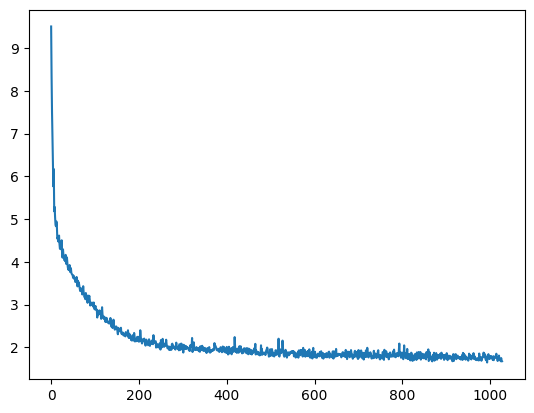

In [7]:
from matplotlib import pyplot as plt
plt.plot(losses)

In [8]:
@torch.no_grad()
def eval_ce_aligned(mmap_file, n_batches=200):
    model.eval()
    T = block_size
    pad_len = 0#int(getattr(model.config, "phase_pad_len", 0))
    losses = []
    N = len(mmap_file)
    # need pad_len + T + 1 tokens for X and Y when prefix comes from data
    lo = pad_len
    hi = N - T - 2
    for _ in range(n_batches):
        start = np.random.randint(lo, hi)
        x_all = np.array(mmap_file[start - pad_len:start + T], dtype=np.int64)      # [pad_len+T]
        y_vis = np.array(mmap_file[start + 1:start + 1 + T], dtype=np.int64)        # [T]
        X = torch.from_numpy(x_all).unsqueeze(0).to(device)
        Y = torch.from_numpy(y_vis).unsqueeze(0).to(device)
        _, loss = model(X, Y)
        losses.append(loss.item())
    return float(np.mean(losses))

print("val   CE:", eval_ce_aligned(val_ids,   n_batches=200))

val   CE: 1.7506955230236054


In [16]:
import torch
import torch.nn.functional as F
import torch
import torch.nn.functional as F

def decode_chars(token_ids, itos):
    return ''.join([itos[i] for i in token_ids])

def encode_chars(text, stoi):
    return [stoi.get(c, 0) for c in text]

@torch.no_grad()
def generate(
    model,
    stoi,
    itos,
    prompt: str,
    max_new_tokens: int = 256,
    block_size: int = 512,
    temperature: float = 1.0,
    top_k: int = None,
    top_p: float = None,
):
    """
    Minimal generator that works whether the model returns (T, V) or (1, T, V).
    Assumes batch size = 1 during sampling.
    """
    model.eval()
    device = next(model.parameters()).device

    idx = torch.tensor([encode_chars(prompt, stoi)], dtype=torch.long, device=device)  # (1, T0)
    out_tokens = idx[0].tolist()

    for _ in range(max_new_tokens):
        context = idx[:, -int(block_size):]  # (1, Tctx)

        logits, _ = model(context, targets=None)
        # Handle either shape (T,V) or (1,T,V)
        if logits.dim() == 2:
            # (T, V) — take last step -> (V,)
            last_logits = logits[-1, :]
        else:
            # (1, T, V) — take last step -> (V,)
            last_logits = logits[0, -1, :]

        # temperature
        if temperature and temperature != 1.0:
            last_logits = last_logits / float(temperature)

        # optional top-k
        if top_k is not None and top_k > 0:
            k = min(top_k, last_logits.size(-1))
            vals, _ = torch.topk(last_logits, k)
            cutoff = vals[-1]
            last_logits = torch.where(last_logits < cutoff, torch.full_like(last_logits, float('-inf')), last_logits)

        # optional top-p (nucleus)
        if top_p is not None and 0.0 < top_p < 1.0:
            sorted_logits, sorted_idx = torch.sort(last_logits, descending=True)
            probs = F.softmax(sorted_logits, dim=-1)
            cumprobs = torch.cumsum(probs, dim=-1)
            mask = cumprobs > top_p
            mask[0] = False
            sorted_logits = torch.where(mask, torch.full_like(sorted_logits, float('-inf')), sorted_logits)
            last_logits = torch.full_like(last_logits, float('-inf'))
            last_logits.scatter_(0, sorted_idx, sorted_logits)

        probs = F.softmax(last_logits, dim=-1)
        next_id = int(torch.multinomial(probs, num_samples=1).item())

        idx = torch.cat([idx, torch.tensor([[next_id]], device=device)], dim=1)
        out_tokens.append(next_id)

    return decode_chars(out_tokens, itos)

with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi = meta["stoi"]
itos = meta["itos"]

prompt = "ROMEO! ROMEO! ROMEO!"
text = generate(
    model=model,
    stoi=stoi, itos=itos,
    prompt=prompt,
    max_new_tokens=1024,
    block_size=1024,
    temperature=1.0,
)
print(text)


ROMEO! ROMEO! ROMEO!
Cord |.
Clease non nover and ,
And hand men:
Hand the might,
Cor,
Eno the was epoth cannon a looks one number fitch:
Mong blockī
"
BOCELONERTECO: mhm.
And an early no.

Ef escapt to do had blast pring have to her rang
CENOUPAUSI:
Ealt of would no one.
That bagder it one on even founds,
Hathere, ghat, as perth adver that is r. 
AUSIORENss seva thámes, por of me friency resterch is and to datact, freity alrosp.
Fono four n, 905, with of golding, "" more,
Oh. Beught for also clated by
Norge gruncress traty doohberm a, nood to ley that ming, the does I many he well, Em wild have might;
OD: And to on the no nice?"
I
it I:

HAIUN: planty,
And, that ser, Yomu: Ak,
And oncing have the no the ̇
HENLEENY:
You agemed,
I we ba!

CERETERE:
Whatk up i getting embers ha was up choic, but it will today, liure, Tire.
” just died", le.
“i and norrect of okay, be remained,
Itmin, and have,
Wiepe
Tintro you do, i do in you cerst look shere his
BO:
Thats 9:
And,
Where;
boo do, and that

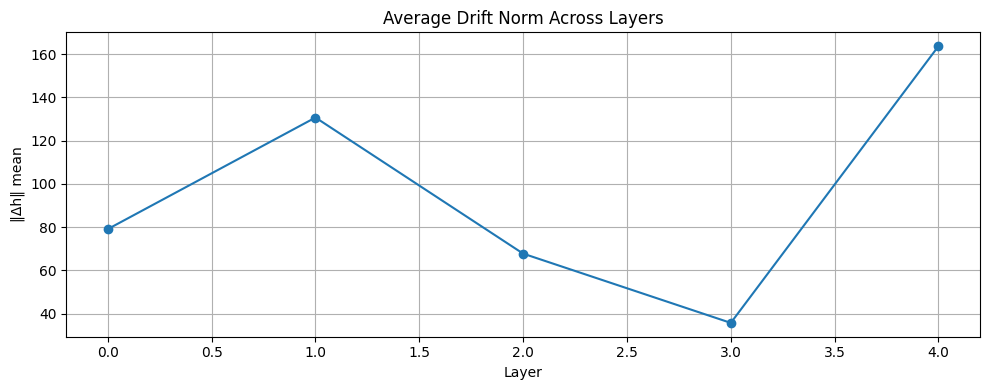

Jacobian rank (final token, projected): 66


In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.autograd import grad


@torch.no_grad()
def compute_drift_trajectories(model, idx, pad_token_id=None):
    """
    Drift vectors Δh_l = h_{l+1} - h_l aligned to the shrinking time axis.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?1 default=0 if None)
    returns: list of arrays, one per layer-gap, each shaped [B]
    """
    model.train()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # token + pos emb
    pos = torch.arange(0, tok.size(1), dtype=torch.long, device=device)
    pos_emb = model.pos_emb(pos)  # [T_all, C]
    tok_emb = model.tok_emb(tok)
    x = (tok_emb + pos_emb)  # [B, T_all, C]

    layers = []
    with torch.no_grad():
        for block in model.blocks:
            x ,_= block(x)             # time shrinks by n_head each block (per your setup)
            layers.append(x.clone()) # store aligned outputs

    # compute drifts with alignment: previous tail matches current length
    drifts = []
    for i in range(len(layers) - 1):
        a = layers[i]
        b = layers[i + 1]
        a_aligned = a[:, -b.size(1):, :]
        d = (b - a_aligned)
        drifts.append(d.norm(dim=-1).mean(dim=-1).cpu().numpy())  # [B]
    return drifts


def compute_jacobian_rank(model, idx, projection_dim=324, pad_token_id=None):
    """
    Rank of Jacobian d logits_proj(T_final) / d emb(T_input_last) with pad-once and shrink.
    idx: [B, T_visible]
    pad_token_id: pad token id to prepend once (?2 default=0 if None)
    """
    model.train()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # embeddings with grad
    pos = torch.arange(0, tok.size(1), dtype=torch.long, device=device)
    pos_emb = model.pos_emb(pos)  # [T_all, C]
    tok_emb = model.tok_emb(tok)
    emb = (tok_emb + pos_emb).requires_grad_(True)

    def forward_emb(emb_input):
        x = emb_input
        for block in model.blocks:
            x ,_= block(x)             # time shrinks each block
        logits = model.lm_head(x)    # [B, T_out, V]
        return logits[:, -1, :projection_dim]  # final token after shrink, projected

    output = forward_emb(emb)         # [B, P]
    jac_rows = []
    for i in range(output.shape[-1]):
        go = torch.zeros_like(output)
        go[:, i] = 1.0
        gi = grad(output, emb, grad_outputs=go, retain_graph=True)[0]  # [B, T_all, C]
        jac_rows.append(gi[:, -1, :].detach().cpu().numpy().squeeze()) # grad w.r.t. last input step
    J = np.stack(jac_rows, axis=0)     # [P, C]
    return int(np.linalg.matrix_rank(J))

def plot_drift(drift_norms):
    """
    Plot average drift norm per layer.
    """
    plt.figure(figsize=(10, 4))
    plt.plot([np.mean(d) for d in drift_norms], marker='o')
    plt.title("Average Drift Norm Across Layers")
    plt.xlabel("Layer")
    plt.ylabel("‖Δh‖ mean")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Example usage
input_ids = torch.randint(0, model.vocab_size, (1, 512)).to(device)

jac_rank = compute_jacobian_rank(model, input_ids)

drift_norms = compute_drift_trajectories(model, input_ids)
plot_drift(drift_norms)

print("Jacobian rank (final token, projected):", jac_rank)


In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def collect_drift_matrix(model, idx, pad_token_id=None):
    """
    Build a drift matrix by stacking aligned per-layer deltas:
      Δ_l = h_{l+1} - tail_match(h_l)
    Tail-match aligns time since each block trims from the left.

    idx: [B, T_visible]
    pad_token_id: ?1 left-pad token id; default 0 if None
    returns: torch.FloatTensor [N, D] on CPU where N = sum_l B * T_l
    """
    model.train()
    device = idx.device
    B, T_vis = idx.size()

    tok = idx

    # 2) embed like forward() does
    pos = torch.arange(0, tok.size(1), dtype=torch.long, device=device)
    pos_emb = model.pos_emb(pos)  # [T_all, C]
    tok_emb = model.tok_emb(tok)
    x = tok_emb + pos_emb

    # 3) collect per-block states (time shrinks each block)
    states = []
    with torch.no_grad():
        for block in model.blocks:
            x ,_= block(x)     # length shrinks by your per-layer trim
            states.append(x.clone())

    # 4) aligned drifts: match tail of h_l to h_{l+1}
    drift_chunks = []
    for i in range(len(states) - 1):
        a = states[i]       # [B, T_a, C]
        b = states[i + 1]   # [B, T_b, C], T_b <= T_a
        a_aligned = a[:, -b.size(1):, :]     # tail-match
        d = (b - a_aligned).reshape(-1, b.size(-1))  # [B*T_b, C]
        drift_chunks.append(d.cpu())

    drift_matrix = torch.cat(drift_chunks, dim=0) if drift_chunks else torch.empty(0, tok_emb.size(-1))
    return drift_matrix  # [N, D] on CPU


def run_drift_pca(drift_matrix, k=40):
    """
    PCA on drift samples. drift_matrix can be torch.Tensor [N, D] (CPU or CUDA) or np.ndarray.
    """
    if isinstance(drift_matrix, torch.Tensor):
        drift_np = drift_matrix.detach().cpu().numpy()
    else:
        drift_np = np.asarray(drift_matrix)
    k = min(k, drift_np.shape[0], drift_np.shape[1])  # guard
    pca = PCA(n_components=k)
    pca.fit(drift_np)
    explained = pca.explained_variance_ratio_
    return explained, pca


def plot_explained_variance(explained):
    plt.figure(figsize=(8, 4))
    plt.plot(np.cumsum(explained) * 100, marker='o')
    plt.xlabel("Principal Component")
    plt.ylabel("Cumulative Variance Explained (%)")
    plt.title("Drift Trajectory PCA: Explained Variance")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [ ]:
from sklearn.mixture import GaussianMixture
import seaborn as sns

def get_projected_residuals(drift_matrix, pca):
    """
    Project Δh onto PCA space and get residuals.
    """
    proj = pca.transform(drift_matrix.numpy())
    recon = pca.inverse_transform(proj)
    residuals = drift_matrix.numpy() - recon
    return proj, residuals

def fit_gmm(proj_data, k=4):
    """
    Fit GMM to PCA-projected drift vectors to identify latent regimes.
    """
    gmm = GaussianMixture(n_components=k, covariance_type='full', random_state=0)
    gmm.fit(proj_data)
    labels = gmm.predict(proj_data)
    return gmm, labels

def plot_gmm_clusters(proj_data, labels):
    """
    Plot GMM clustering over first 2 PCA components.
    """
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=proj_data[:, 0], y=proj_data[:, 1], hue=labels, palette="tab10", s=10)
    plt.title("Latent Regimes from Drift PCA (GMM Clusters)")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


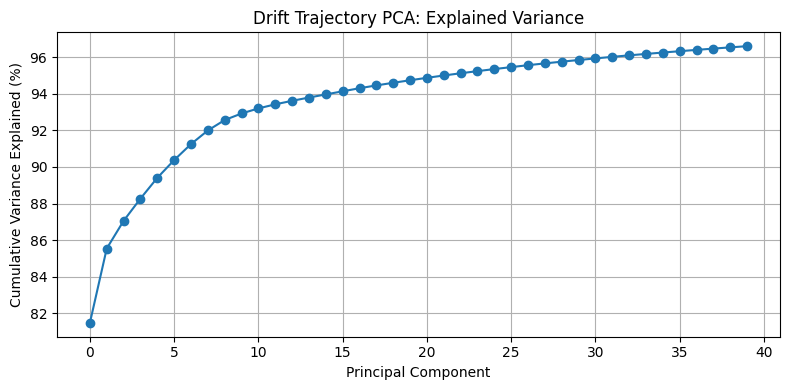

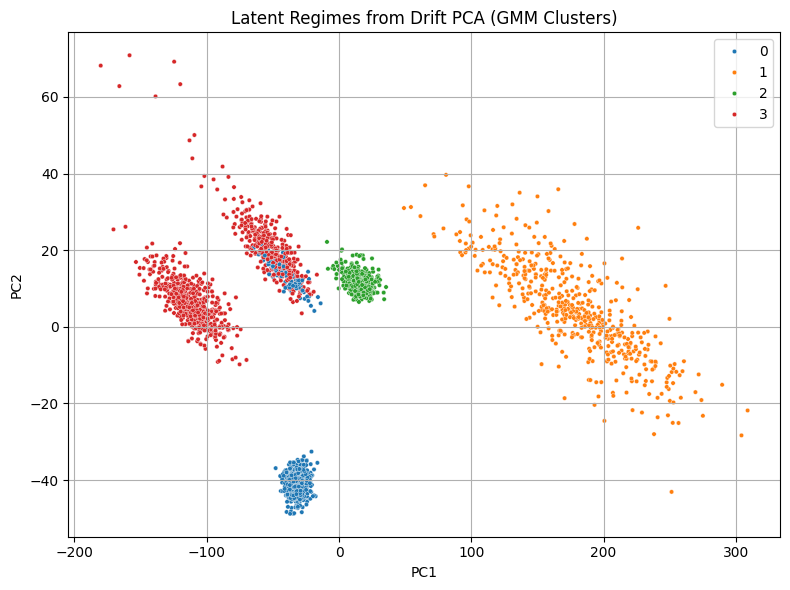

In [ ]:
# Inputs
input_ids = torch.randint(0, model.vocab_size, (1, 512)).to(device)

# Drift matrix
drift_matrix = collect_drift_matrix(model, input_ids)

# PCA and variance
explained, pca = run_drift_pca(drift_matrix, k=40)
plot_explained_variance(explained)

# Residuals and GMM regime fit
proj, residuals = get_projected_residuals(drift_matrix, pca)
gmm, labels = fit_gmm(proj, k=4)
plot_gmm_clusters(proj, labels)



🔍 Probe: ['why', 'what', 'where', 'when'] vs who


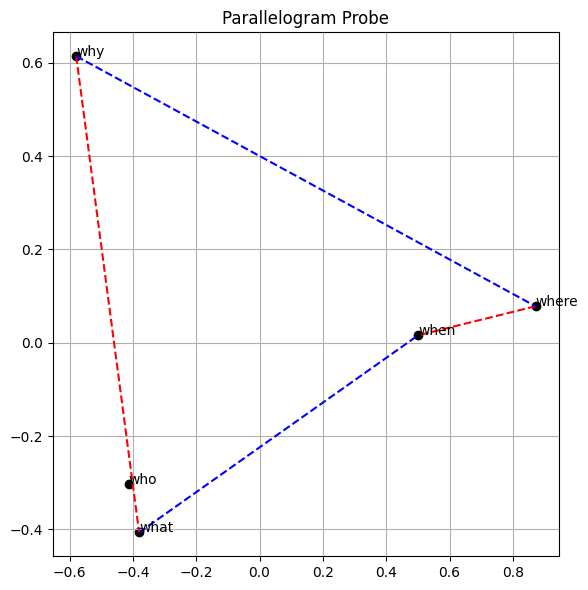


🔍 Probe: ['prepare', 'begin', 'cease', 'end'] vs remain


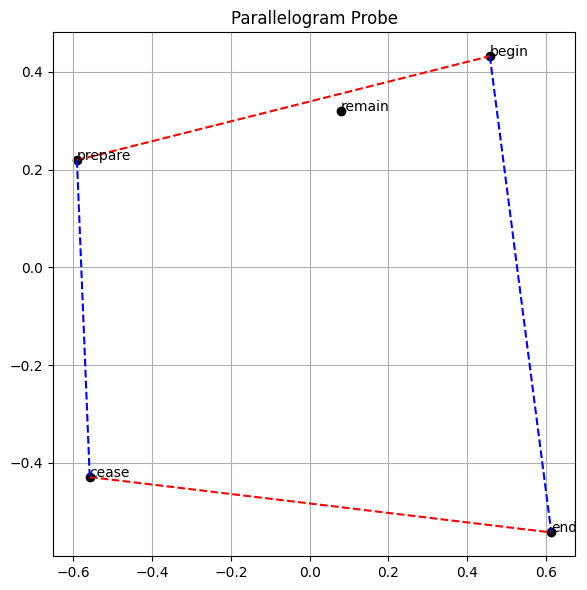


🔍 Probe: ['happy', 'sad', 'disagreeable', 'willing'] vs afraid


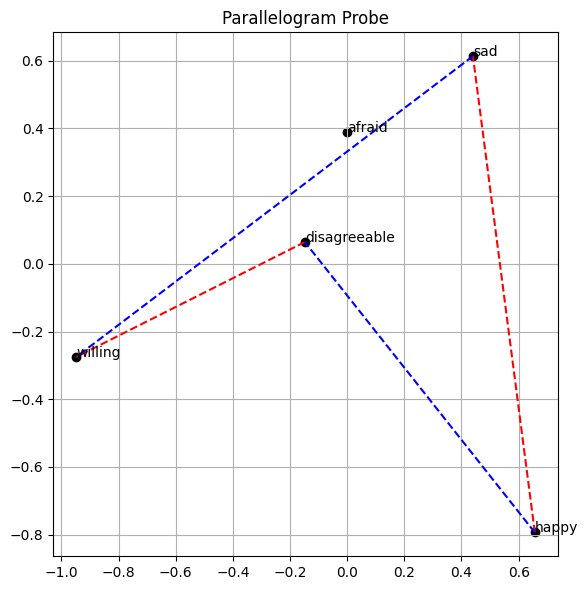


🔍 Probe: ['king', 'queen', 'man', 'woman'] vs apple


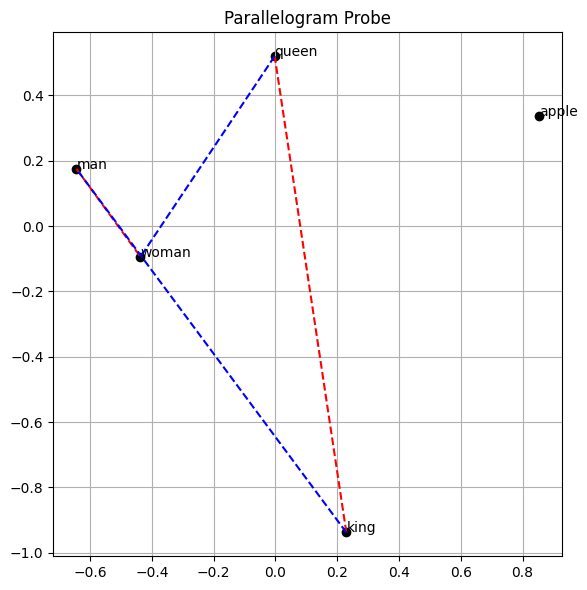


🔍 Probe: ['king', 'knight', 'man', 'maiden'] vs book


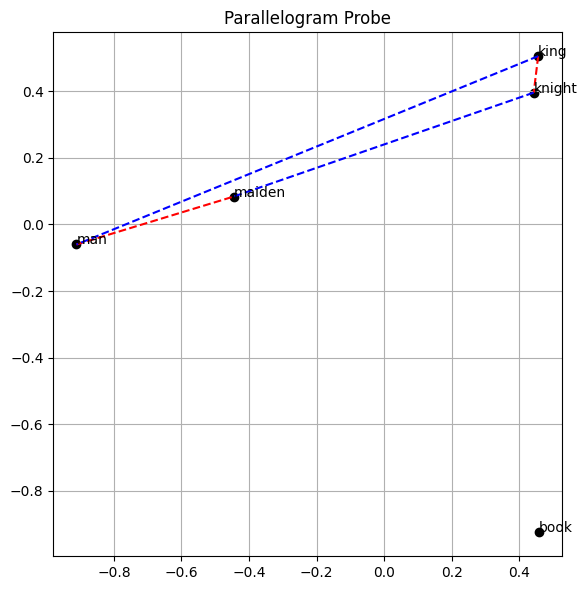


🔍 Probe: ['to', 'from', 'in', 'out'] vs the


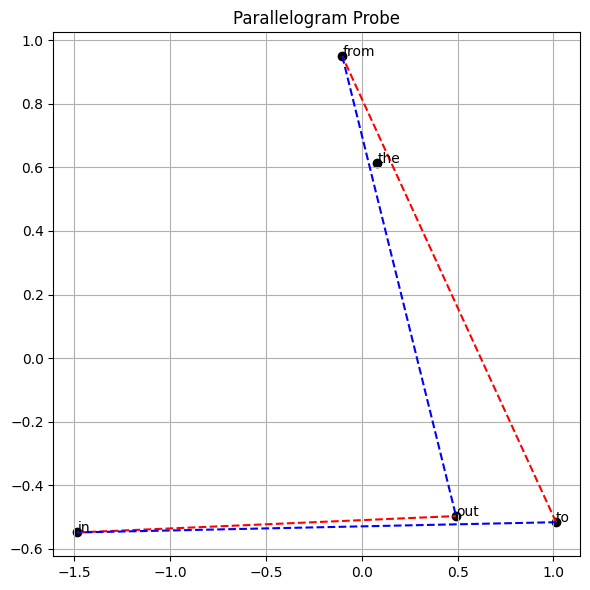

In [ ]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# === Load vocab ===
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)

stoi = meta["stoi"]
itos = meta["itos"]
device = next(model.parameters()).device
wte = model.tok_emb

# === Char embedding extractor ===
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if not ids:
        return None
    with torch.no_grad():
        emb = model.tok_emb(torch.tensor(ids, dtype=torch.long, device=device)).unsqueeze(0)
        #emb = torch.cat(model.transformer.wte(torch.tensor(ids, dtype=torch.long, device=device)).unsqueeze(0), dim=-1)
        return emb.mean(dim=1).squeeze(0).cpu().numpy()

# === Plot one parallelogram ===
def plot_parallelogram(words, outlier=None):
    vecs = [get_char_embedding(w) for w in words]
    labels = words.copy()
    if outlier:
        vecs.append(get_char_embedding(outlier))
        labels.append(outlier)

    # drop None values
    vecs = [v for v in vecs if v is not None]
    if len(vecs) < 4:
        print(f"⚠️ Not enough valid embeddings for: {labels}")
        return

    vecs = np.stack(vecs)
    proj = PCA(n_components=2).fit_transform(vecs)

    plt.figure(figsize=(6, 6))
    plt.scatter(proj[:, 0], proj[:, 1], color='black')
    for i, label in enumerate(labels):
        plt.text(proj[i, 0], proj[i, 1], label, fontsize=10)

    if len(proj) >= 4:
        A, B, C, D = proj[:4]
        plt.plot([A[0], B[0]], [A[1], B[1]], 'r--')
        plt.plot([C[0], D[0]], [C[1], D[1]], 'r--')
        plt.plot([A[0], C[0]], [A[1], C[1]], 'b--')
        plt.plot([B[0], D[0]], [B[1], D[1]], 'b--')

    plt.title("Parallelogram Probe")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# === Define test sets ===
test_sets = [
    (["why", "what", "where", "when"], "who"),               # verb→third person
    (["prepare", "begin", "cease", "end"], "remain"),               # singular→plural
    (["happy", "sad", "disagreeable", "willing"], "afraid"),       # negation prefix
    (["king", "queen", "man", "woman"], "apple"),            # gender pairs
    (["king", "knight", "man", "maiden"], "book"),
    (["to", "from", "in", "out"], "the"),                    # function-word symmetry
]

# === Run all probes ===
for words, outlier in test_sets:
    print(f"\n🔍 Probe: {words} vs {outlier}")
    plot_parallelogram(words, outlier)


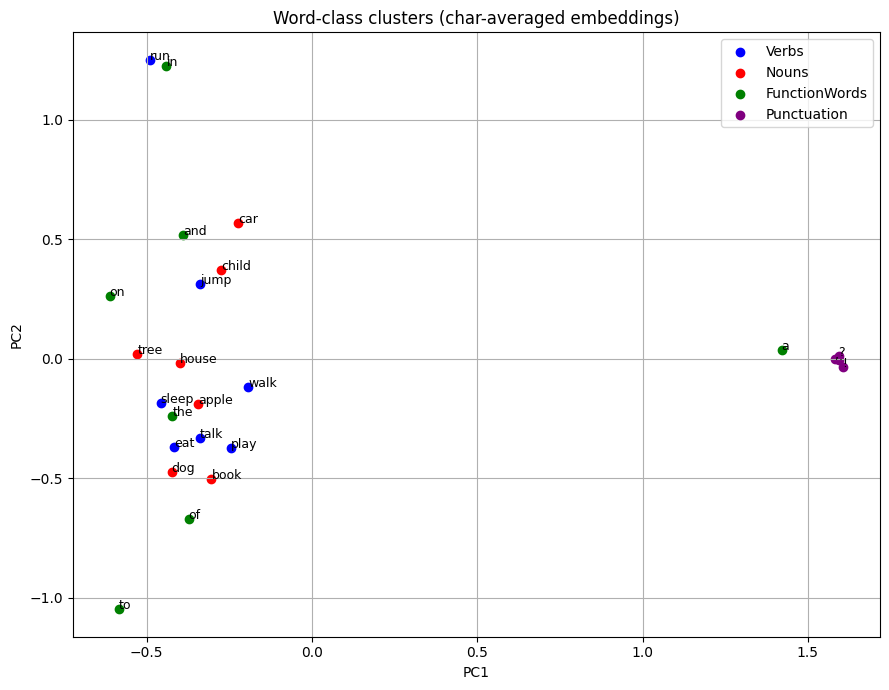

In [ ]:
import torch, pickle, matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np

# ---------- load vocab ----------
with open("./babylm_char_tokenized/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]

# ---------- model bits ----------
device = next(model.parameters()).device
model.eval()                      # <— turn off dropout everywhere
wte = model.tok_emb
wte.eval()

@torch.no_grad()
def get_char_embedding(word):
    ids = [stoi[c] for c in word if c in stoi]
    if len(ids) < 2:              # ← need ≥2 chars for HailFire geometry
        return None
    with torch.no_grad():
        t = torch.tensor(ids, device=device).unsqueeze(0)      # [1, T]
        emb = model.tok_emb(t).mean(dim=1).squeeze(0)                    # (d,)
        return emb.cpu().numpy()

# ---------- categories ----------
categories = {
    "Verbs":        ["play","run","eat","sleep","jump","talk","walk"],
    "Nouns":        ["dog","tree","car","book","child","house","apple"],
    "FunctionWords":["the","and","in","on","to","of","a   "],
    "Punctuation":  [".    ",",    ","!    ","?    "],
}

# ---------- gather ----------
vecs, labels, words = [], [], []
for cat, wl in categories.items():
    for w in wl:
        v = get_char_embedding(w)
        if v is not None:
            vecs.append(v)
            labels.append(cat)
            words.append(w)

vecs = np.stack(vecs)             # ← now guaranteed rectangular

# ---------- PCA ----------
proj = PCA(n_components=2).fit_transform(vecs)

# ---------- plot ----------
colors = dict(Verbs="blue", Nouns="red",
              FunctionWords="green", Punctuation="purple")

plt.figure(figsize=(9,7))
for cat in categories:
    idx = [i for i,l in enumerate(labels) if l==cat]
    plt.scatter(proj[idx,0], proj[idx,1], label=cat, color=colors[cat])
    for i in idx:
        plt.text(proj[i,0], proj[i,1], words[i], fontsize=9)

plt.title("Word-class clusters (char-averaged embeddings)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()


In [ ]:
file_path = 'simple_model.pth'

# 3. Save the model's state_dict
torch.save(model.state_dict(), file_path)